# Loading the relevant libraries

In [2]:
import os
import pandas as pd 
import numpy as np
import torch
import torchvision
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [3]:
imagenet_label_list = pd.read_csv(r"/home/junzhin/Project/Summer_project/code/version1.0/imagenet_labels_set.txt", sep = " ",header = None)

In [4]:
imagenet_label_list_dict = dict(zip(imagenet_label_list[2].apply(lambda x: x.lower()), imagenet_label_list[0]))


# Checking the directory of the imagenet and make sure the existence and presence of the labels

In [5]:
your_path =r"/data/gpfs/datasets/Imagenet/" 
file_dir = os.listdir(your_path)
file_dir

['face_annotations_ILSVRC.json', 'train_blurred', 'val_blurred']

In [6]:
train_filenames = os.listdir(your_path + file_dir[1])
valid_filenames = os.listdir(your_path + file_dir[2])
print(len(train_filenames))
print(len(valid_filenames))

1000
1000


In [7]:
print(set(train_filenames) == set(valid_filenames))

True


In [8]:
imagenet_training_filePath = os.path.join(your_path, file_dir[1])
imagenet_valid_filePath = os.path.join(your_path, file_dir[2])


In [9]:

image_net_train_dataset = datasets.ImageFolder(
        imagenet_training_filePath)


# Open the office31 dataset and extract the labels 

In [10]:
office31_path =r"/home/junzhin/Project/datasets/domain_adaptation_images/"
office31_dir = os.listdir(office31_path)
amazon_file_path = os.path.join(office31_path, office31_dir[0]+ "/images/")
dslr_file_path = os.path.join(office31_path, office31_dir[1]+ "/images/")
webcam_file_path = os.path.join(office31_path, office31_dir[2]+ "/images/")
print(office31_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/home/junzhin/Project/datasets/domain_adaptation_images/'

## Checking if three domains have the same set of class labels

In [ ]:
amazon =  os.listdir(amazon_file_path)
dslr =  os.listdir(dslr_file_path)
webcam =  os.listdir(webcam_file_path)
 

In [ ]:
print(set(amazon) == set(dslr) == set(webcam))

True


## Loading one of the domains of the class labels for further manipulation

In [ ]:
office_31_train_dataset = datasets.ImageFolder(
        amazon_file_path)
office_31_train_dataset



Dataset ImageFolder
    Number of datapoints: 2817
    Root location: /home/junzhin/Project/datasets/domain_adaptation_images/amazon/images/

In [ ]:
print(dict(Counter(office_31_train_dataset.targets)))
office_31_training_labels = office_31_train_dataset.classes
print(office_31_train_dataset.classes[:])

{0: 92, 1: 82, 2: 72, 3: 82, 4: 36, 5: 94, 6: 91, 7: 97, 8: 97, 9: 81, 10: 99, 11: 100, 12: 100, 13: 98, 14: 100, 15: 99, 16: 100, 17: 94, 18: 96, 19: 95, 20: 93, 21: 100, 22: 98, 23: 98, 24: 90, 25: 75, 26: 100, 27: 99, 28: 99, 29: 96, 30: 64}
['back_pack', 'bike', 'bike_helmet', 'bookcase', 'bottle', 'calculator', 'desk_chair', 'desk_lamp', 'desktop_computer', 'file_cabinet', 'headphones', 'keyboard', 'laptop_computer', 'letter_tray', 'mobile_phone', 'monitor', 'mouse', 'mug', 'paper_notebook', 'pen', 'phone', 'printer', 'projector', 'punchers', 'ring_binder', 'ruler', 'scissors', 'speaker', 'stapler', 'tape_dispenser', 'trash_can']


In [ ]:
selected_index = [ office_31_train_dataset.class_to_idx[i] for i in office_31_train_dataset.classes[:20]]
print(selected_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
trainset_1 = torch.utils.data.Subset(office_31_train_dataset, selected_index)
train_loader = torch.utils.data.DataLoader(trainset_1, batch_size=2, shuffle= False, num_workers=1, pin_memory=True,sampler=None)
print(len(trainset_1))
print(len(train_loader))

20
10


## Checking the duplicate classes between the imagenet of 1000 classes and office31

In [ ]:
office_31_training_labels = [word.lower().replace("_", " ") for word in office_31_training_labels]

In [ ]:
imagenet_label_list = [word.lower().replace("_", " ") for word in imagenet_label_list[2]]

### Method 1: Exact string match between two datasets classes

In [ ]:
masked_list1 = set(office_31_training_labels).intersection(set(imagenet_label_list))

### Method 2 Similarity string matching between two datasets classes: To remove any possible similar strings in both set of classes

In [ ]:
import textdistance

In [ ]:
def find_similars_dict(source_labels, target_labels, threshold = 1.0):
    similarity_dict =  {}
    for x in source_labels:
        similarity_dict[x] = []
        for y in target_labels:
            similarity_score = textdistance.smith_waterman.normalized_similarity(x,y)
            if similarity_score >= threshold:
                similarity_dict[x].append([y,similarity_score])
    for each_word_list in similarity_dict:
        similarity_dict[each_word_list].sort(key=lambda x: x[1], reverse = True)
    # levenshtein damerau_levenshtein gotoh smith_waterman
    return similarity_dict

In [ ]:
similarity_dict = find_similars_dict(office_31_training_labels,imagenet_label_list,threshold = 1)

In [ ]:
similarity_dict

{'back pack': [],
 'bike': [['mountain bike', 1.0]],
 'bike helmet': [],
 'bookcase': [['bookcase', 1.0]],
 'bottle': [['beer bottle', 1.0],
  ['pop bottle', 1.0],
  ['wine bottle', 1.0],
  ['pill bottle', 1.0],
  ['water bottle', 1.0]],
 'calculator': [],
 'desk chair': [],
 'desk lamp': [],
 'desktop computer': [['desktop computer', 1.0]],
 'file cabinet': [],
 'headphones': [],
 'keyboard': [['computer keyboard', 1.0], ['typewriter keyboard', 1.0]],
 'laptop computer': [],
 'letter tray': [['tray', 1.0]],
 'mobile phone': [],
 'monitor': [['monitor', 1.0]],
 'mouse': [['mouse', 1.0]],
 'mug': [['coffee mug', 1.0]],
 'paper notebook': [['notebook', 1.0]],
 'pen': [['fountain pen', 1.0]],
 'phone': [['microphone', 1.0],
  ['pay-phone', 1.0],
  ['cellular telephone', 1.0],
  ['dial telephone', 1.0]],
 'printer': [['printer', 1.0]],
 'projector': [['projector', 1.0]],
 'punchers': [],
 'ring binder': [['binder', 1.0]],
 'ruler': [],
 'scissors': [],
 'speaker': [['loudspeaker', 1.0]],
 

In [ ]:
masked_list2 = set()
for key in similarity_dict:
    for values in similarity_dict[key]:
        masked_list2.add(values[0])
print(masked_list2)

{'fountain pen', 'loudspeaker', 'tray', 'dial telephone', 'mountain bike', 'beer bottle', 'desktop computer', 'coffee mug', 'typewriter keyboard', 'monitor', 'water bottle', 'pay-phone', 'pop bottle', 'printer', 'pill bottle', 'binder', 'bookcase', 'projector', 'notebook', 'wine bottle', 'microphone', 'cellular telephone', 'computer keyboard', 'mouse'}


## Save them into files:

In [ ]:
masked_list1 = [x.replace(" ", "_") for x in masked_list1]
masked_list2 = [x.replace(" ", "_") for x in masked_list2]
print(masked_list1)
print(masked_list2)

['desktop_computer', 'printer', 'monitor', 'bookcase', 'mouse', 'projector']
['fountain_pen', 'loudspeaker', 'tray', 'dial_telephone', 'mountain_bike', 'beer_bottle', 'desktop_computer', 'coffee_mug', 'typewriter_keyboard', 'monitor', 'water_bottle', 'pay-phone', 'pop_bottle', 'printer', 'pill_bottle', 'binder', 'bookcase', 'projector', 'notebook', 'wine_bottle', 'microphone', 'cellular_telephone', 'computer_keyboard', 'mouse']


In [ ]:
masked_list1_df = pd.DataFrame([(imagenet_label_list_dict[i], i) for i in masked_list1])
masked_list2_df = pd.DataFrame([(imagenet_label_list_dict[i], i) for i in masked_list2])
masked_list1_df.to_csv('masked_office31_imagenetlabel1_df.csv',index = False, header = False)
masked_list2_df.to_csv('masked_office31_imagenetlabel2_df.csv',index = False, header = False)


# Open the officehome dataset and extract the labels 

In [ ]:
officehome_path =r"/home/junzhin/Project/datasets/OfficeHomeDataset_10072016"
officehome_dir = os.listdir(officehome_path)
art_file_path = os.path.join(officehome_path, officehome_dir[0])
clipart_file_path = os.path.join(officehome_path, officehome_dir[1])
product_file_path = os.path.join(officehome_path, officehome_dir[4])
world_file_path = os.path.join(officehome_path, officehome_dir[5])

In [ ]:
print(officehome_path)
print(officehome_dir)

/home/junzhin/Project/datasets/OfficeHomeDataset_10072016
['Art', 'Clipart', 'ImageInfo.csv', 'imagelist.txt', 'Product', 'Real World']


In [ ]:
art =  os.listdir(art_file_path)
clipart =  os.listdir(clipart_file_path)
product =  os.listdir(product_file_path)
world =  os.listdir(world_file_path)
print(set(art) == set(clipart) == set(product) == set(world))
print(len(set(art)))

True
65


## Choosing one of the domains for labels extractions:


In [ ]:
office_home_train_dataset = datasets.ImageFolder(art_file_path)
office_home_train_dataset.classes
office_home_label_list = [i.lower().replace("_", " ") for i in office_home_train_dataset.classes]
print(office_home_train_dataset.classes)
print(len(office_home_train_dataset.classes))

['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calculator', 'Calendar', 'Candles', 'Chair', 'Clipboards', 'Computer', 'Couch', 'Curtains', 'Desk_Lamp', 'Drill', 'Eraser', 'Exit_Sign', 'Fan', 'File_Cabinet', 'Flipflops', 'Flowers', 'Folder', 'Fork', 'Glasses', 'Hammer', 'Helmet', 'Kettle', 'Keyboard', 'Knives', 'Lamp_Shade', 'Laptop', 'Marker', 'Monitor', 'Mop', 'Mouse', 'Mug', 'Notebook', 'Oven', 'Pan', 'Paper_Clip', 'Pen', 'Pencil', 'Postit_Notes', 'Printer', 'Push_Pin', 'Radio', 'Refrigerator', 'Ruler', 'Scissors', 'Screwdriver', 'Shelf', 'Sink', 'Sneakers', 'Soda', 'Speaker', 'Spoon', 'TV', 'Table', 'Telephone', 'ToothBrush', 'Toys', 'Trash_Can', 'Webcam']
65


In [ ]:
masked_list1 = set(office_home_label_list).intersection(set(imagenet_label_list))
masked_list1

{'backpack',
 'bucket',
 'hammer',
 'laptop',
 'monitor',
 'mouse',
 'notebook',
 'printer',
 'radio',
 'refrigerator',
 'screwdriver'}

In [ ]:
similarity_dict = find_similars_dict(office_home_label_list, imagenet_label_list,threshold = 1)

In [ ]:
similarity_dict

{'alarm clock': [],
 'backpack': [['backpack', 1.0]],
 'batteries': [],
 'bed': [],
 'bike': [['mountain bike', 1.0]],
 'bottle': [['beer bottle', 1.0],
  ['pop bottle', 1.0],
  ['wine bottle', 1.0],
  ['pill bottle', 1.0],
  ['water bottle', 1.0]],
 'bucket': [['bucket', 1.0]],
 'calculator': [],
 'calendar': [],
 'candles': [],
 'chair': [['barber chair', 1.0],
  ['folding chair', 1.0],
  ['rocking chair', 1.0]],
 'clipboards': [],
 'computer': [['desktop computer', 1.0], ['hand-held computer', 1.0]],
 'couch': [['studio couch', 1.0]],
 'curtains': [],
 'desk lamp': [],
 'drill': [['power drill', 1.0]],
 'eraser': [['rubber eraser', 1.0]],
 'exit sign': [],
 'fan': [['electric fan', 1.0]],
 'file cabinet': [],
 'flipflops': [],
 'flowers': [],
 'folder': [],
 'fork': [],
 'glasses': [['sunglasses', 1.0]],
 'hammer': [['hammer', 1.0]],
 'helmet': [['crash helmet', 1.0], ['football helmet', 1.0]],
 'kettle': [],
 'keyboard': [['computer keyboard', 1.0], ['typewriter keyboard', 1.0]],
 

In [ ]:
masked_list2 = set()
for key in similarity_dict:
    for values in similarity_dict[key]:
        masked_list2.add(values[0])
print(masked_list2)

{'fountain pen', 'refrigerator', 'power drill', 'loudspeaker', 'barber chair', 'electric fan', 'studio couch', 'dial telephone', 'backpack', 'mountain bike', 'laptop', 'beer bottle', 'dining table', 'bucket', 'desktop computer', 'coffee mug', 'typewriter keyboard', 'folding chair', 'monitor', 'crash helmet', 'dutch oven', 'wooden spoon', 'radio', 'pool table', 'water bottle', 'pop bottle', 'hand-held computer', 'sunglasses', 'hammer', 'printer', 'rocking chair', 'pill bottle', 'screwdriver', 'wine bottle', 'rubber eraser', 'frying pan', 'notebook', 'cellular telephone', 'computer keyboard', 'mouse', 'football helmet'}


## Save them into files

In [ ]:
masked_list1 = [x.replace(" ", "_") for x in masked_list1]
masked_list2 = [x.replace(" ", "_") for x in masked_list2]
print(masked_list1)
print(masked_list2)

['laptop', 'bucket', 'screwdriver', 'refrigerator', 'printer', 'hammer', 'monitor', 'notebook', 'radio', 'mouse', 'backpack']
['fountain_pen', 'refrigerator', 'power_drill', 'loudspeaker', 'barber_chair', 'electric_fan', 'studio_couch', 'dial_telephone', 'backpack', 'mountain_bike', 'laptop', 'beer_bottle', 'dining_table', 'bucket', 'desktop_computer', 'coffee_mug', 'typewriter_keyboard', 'folding_chair', 'monitor', 'crash_helmet', 'dutch_oven', 'wooden_spoon', 'radio', 'pool_table', 'water_bottle', 'pop_bottle', 'hand-held_computer', 'sunglasses', 'hammer', 'printer', 'rocking_chair', 'pill_bottle', 'screwdriver', 'wine_bottle', 'rubber_eraser', 'frying_pan', 'notebook', 'cellular_telephone', 'computer_keyboard', 'mouse', 'football_helmet']


In [ ]:
masked_list1_df = pd.DataFrame([(imagenet_label_list_dict[i], i) for i in masked_list1])
masked_list2_df = pd.DataFrame([(imagenet_label_list_dict[i], i) for i in masked_list2])
masked_list1_df.to_csv('masked_officehome_imagenetlabel1_df.csv',index = False, header = False)
masked_list2_df.to_csv('masked_officehome_imagenetlabel2_df.csv',index = False, header = False)

In [ ]:
import  matplotlib.pyplot as plt
def dataview(number_of_samples, imageset, classename,imagenet_label_list_dict):
    target_index = imageset.class_to_idx[imagenet_label_list_dict[classename]]
    for index in range(len(imageset)):
        if imageset.imgs[index][1] == target_index:
            break
           
    for i in range(number_of_samples):
        plt.figure()
        plt.imshow(imageset[index + i][0])
        #print(imageset.imgs[index + i])
    return 

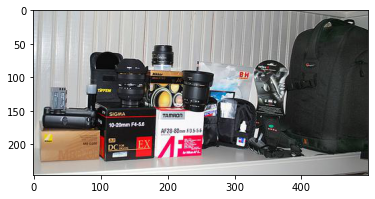

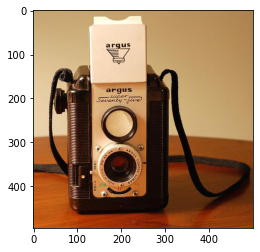

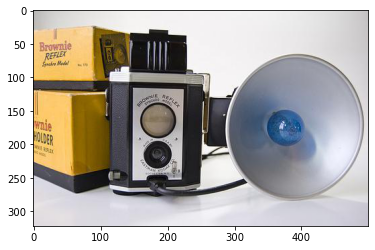

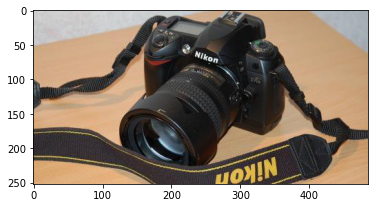

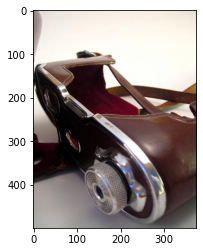

In [ ]:
dataview(5,image_net_train_dataset,"reflex_camera",imagenet_label_list_dict)

## Experiment of choosing the subset of the dataset

In [1]:
image_net_train_dataset = datasets.ImageFolder(
        imagenet_training_filePath)
print(image_net_train_dataset)



image_net_valid_dataset = datasets.ImageFolder(
        imagenet_valid_filePath)
print(image_net_valid_dataset)


NameError: name 'datasets' is not defined

In [ ]:
masked_label_list_office31 = pd.read_csv(r"/home/junzhin/Project/Summer_project/code/version1.0/masked_office31_imagenetlabel2_df.csv", header = None)
masked_label_list_officehome = pd.read_csv(r"/home/junzhin/Project/Summer_project/code/version1.0/masked_officehome_imagenetlabel2_df.csv", header = None)

In [ ]:
chosen_index_office31 = [image_net_train_dataset.class_to_idx[i] for i in image_net_train_dataset.classes if i not in list(masked_label_list_office31[0])]
print(len(chosen_index_office31))
chosen_index_officehome = [image_net_train_dataset.class_to_idx[i]  for i in image_net_train_dataset.classes if i not in list(masked_label_list_officehome[0])]
print(len(chosen_index_officehome))

976
959


In [ ]:
masked_image_net_train_dataset_office31 = torch.utils.data.Subset(image_net_train_dataset, chosen_index_office31)
masked_image_net_train_dataset_officehome = torch.utils.data.Subset(image_net_train_dataset, chosen_index_officehome)

In [ ]:
print(len(masked_image_net_train_dataset_office31))

976


## Random selection after masking the labels in the imagenet

In [4]:
train_dataset_initial = datasets.ImageFolder(r"/data/gpfs/datasets/Imagenet/train_blurred")

In [5]:
filepath =  r'/home/junzhin/Project/Summer_project/code/version1.0/masked_office31_imagenetlabel2_manual_df.csv'#r'/home/junzhin/Project/Summer_project/code/version1.0/masked_officehome_imagenetlabel2_manual_df.csv'
masked_label_list = pd.read_csv(filepath, header = None)
masked_label_list.sort_values(0, inplace = True)
masked_label_list.drop_duplicates(inplace = True)
masked_label_list.reset_index(drop=True, inplace = True)
masked_label_list.to_csv(filepath, index = False, header = False)

In [6]:
import random
# fix the random seed to produce the replicable sampling results
random.seed(1000)
# select the classes after excluding the masked classes 
exclude_masked_classes = [one_class for one_class in train_dataset_initial.classes if one_class not in list(masked_label_list[0])]
print(len(exclude_masked_classes))
random_selected_classes = random.sample(exclude_masked_classes, len(masked_label_list))
chosen_classes = [train_dataset_initial.class_to_idx[each] for each in train_dataset_initial.classes if each not in random_selected_classes]
print(len(chosen_classes))

958
958


In [7]:
chosen_index_train = [index for index in range(len(train_dataset_initial)) if train_dataset_initial.imgs[index][1] in chosen_classes]
# chosen_index_valid = [ index for index in range(len(valid_dataset_initial)) if valid_dataset_initial.imgs[index][1] not in chosen_classes]
train_dataset = torch.utils.data.Subset(train_dataset_initial, chosen_index_train)
# valid_dataset = torch.utils.data.Subset(valid_dataset_initial, chosen_index_valid)
print(len(train_dataset))

1227158


In [12]:
print(train_dataset_initial.class_to_idx)
remap_dict = { x:i for i, x in enumerate(chosen_classes)}
print(remap_dict)

{'n01440764': 0, 'n01443537': 1, 'n01484850': 2, 'n01491361': 3, 'n01494475': 4, 'n01496331': 5, 'n01498041': 6, 'n01514668': 7, 'n01514859': 8, 'n01518878': 9, 'n01530575': 10, 'n01531178': 11, 'n01532829': 12, 'n01534433': 13, 'n01537544': 14, 'n01558993': 15, 'n01560419': 16, 'n01580077': 17, 'n01582220': 18, 'n01592084': 19, 'n01601694': 20, 'n01608432': 21, 'n01614925': 22, 'n01616318': 23, 'n01622779': 24, 'n01629819': 25, 'n01630670': 26, 'n01631663': 27, 'n01632458': 28, 'n01632777': 29, 'n01641577': 30, 'n01644373': 31, 'n01644900': 32, 'n01664065': 33, 'n01665541': 34, 'n01667114': 35, 'n01667778': 36, 'n01669191': 37, 'n01675722': 38, 'n01677366': 39, 'n01682714': 40, 'n01685808': 41, 'n01687978': 42, 'n01688243': 43, 'n01689811': 44, 'n01692333': 45, 'n01693334': 46, 'n01694178': 47, 'n01695060': 48, 'n01697457': 49, 'n01698640': 50, 'n01704323': 51, 'n01728572': 52, 'n01728920': 53, 'n01729322': 54, 'n01729977': 55, 'n01734418': 56, 'n01735189': 57, 'n01737021': 58, 'n0173

In [15]:
target = torch.tensor([0,999, 887])
target = target.map(lambda x: remap_dict[x])

AttributeError: 'Tensor' object has no attribute 'map'

In [8]:
label_set = set([train_dataset_initial.imgs[index][1] for index in range(len(train_dataset_initial)) if train_dataset_initial.imgs[index][1] in chosen_classes])

In [9]:
print(chosen_index_train[:100])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
